In [1]:
import pandas as pd
import numpy as np

In [19]:
data = pd.read_excel('../data/final_data.xlsx')

# choose class
data = data[data['Classe Vela'] == '49erFX']

In [20]:
data.head(30)

,ID Resultado,ID Competidor,Nome Competidor,ID Competição,Classe Vela,Pontuação Regata,Descarte,Flotilha,Posição Geral,Punição,Pontuação Total,Nett,Nome Competição
87823,87824,2062,"ALEKSANDRA MELZACKA, SANDRA JANKOWIAK",4.0,49erFX,13,0.0,GERAL,37,NaN,180.0,142.0,European Championship 2021
87824,87825,2062,"ALEKSANDRA MELZACKA, SANDRA JANKOWIAK",4.0,49erFX,3,0.0,GERAL,37,NaN,180.0,142.0,European Championship 2021
87825,87826,2062,"ALEKSANDRA MELZACKA, SANDRA JANKOWIAK",4.0,49erFX,16,0.0,GERAL,37,NaN,180.0,142.0,European Championship 2021
87826,87827,2062,"ALEKSANDRA MELZACKA, SANDRA JANKOWIAK",4.0,49erFX,22,0.0,GERAL,37,NaN,180.0,142.0,European Championship 2021
87827,87828,2062,"ALEKSANDRA MELZACKA, SANDRA JANKOWIAK",4.0,49erFX,8,0.0,GERAL,37,NaN,180.0,142.0,European Championship 2021
87828,87829,2062,"ALEKSANDRA MELZACKA, SANDRA JANKOWIAK",4.0,49erFX,6,0.0,GERAL,37,NaN,180.0,142.0,European Championship 2021
87829,87830,2062,"ALEKSANDRA MELZACKA, SANDRA JANKOWIAK",4.0,49erFX,7,0.0,GERAL,37,NaN,180.0,142.0,European Championship 2021
87830,87831,2062,"ALEKSANDRA MELZACKA, SANDRA JANKOWIAK",4.0,49erFX,5,0.0,GERAL,37,NaN,180.0,142.0,European Championship 2021
87831,87832,2062,"ALEKSANDRA MELZACKA, SANDRA JANKOWIAK",4.0,49erFX,2,0.0,GERAL,37,NaN,180.0,142.0,European Championship 2021
87832,87833,2062,"ALEKSANDRA MELZACKA, SANDRA JANKOWIAK",4.0,49erFX,38,1.0,GERAL,37,NaN,180.0,142.0,European Championship 2021


In [12]:
# create dictionary to map competitor names to unique indices
competitor_to_index = {competitor: idx for idx, competitor in enumerate(data['Nome Competidor'].unique())}

# create matrix of size (n_players, n_players) with zeros
n_players = len(competitor_to_index)
matrix_alpha = np.zeros((n_players, n_players))
matrix_beta = np.zeros((n_players, n_players))

# iterate through competitions
for competition in data['Nome Competição'].unique():
    # get data for this competition
    data_competition = data[data['Nome Competição'] == competition]
    data_competition = data_competition.drop_duplicates(subset='Nome Competidor', keep='first')

    # get list of competitors in this competition
    competitors = data_competition['Nome Competidor'].unique()
    # get number of competitors in this competition
    n_players = len(competitors)
    print(n_players)
    
    # iterate through competitors in this competition setting (i, j) = 1 if i beats j in this competition
    # get i and j from the dictionary
    for i in range(n_players):
        for j in range(n_players):
            competitor_i = competitors[i]
            competitor_j = competitors[j]
            posicao_i = data_competition[(data_competition['Nome Competidor'] == competitor_i)]['Posição Geral'].values[0]
            print(posicao_i)
            posicao_j = data_competition[(data_competition['Nome Competidor'] == competitor_j)]['Posição Geral'].values[0]
            print(posicao_j)
            pontuacao_i = data_competition[(data_competition['Nome Competidor'] == competitor_i)]['Pontuação Total'].values[0]
            pontuacao_j = data_competition[(data_competition['Nome Competidor'] == competitor_j)]['Pontuação Total'].values[0]

            # get index of competitor i and j in the matrix
            index_i = competitor_to_index[competitor_i]
            index_j = competitor_to_index[competitor_j]

            if posicao_i < posicao_j:
                # update the cumulative matrix
                matrix_alpha[index_i][index_j] += 1
                # update matrix beta with difference in points
                matrix_beta[index_i][index_j] += (pontuacao_i - pontuacao_j)/ pontuacao_i + pontuacao_j

61
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
3

KeyboardInterrupt: 

In [8]:
#checking results
write_matrix = pd.DataFrame(matrix_alpha)

# columns and index are the names of the competitors
write_matrix.columns = competitor_to_index.keys()
write_matrix.index = competitor_to_index.keys()

In [10]:
write_matrix

,"ADAM GLOGOWSKI, MACIEJ KRUSIEC","AKIRA SAKAI, RUSSELL AYLSWORTH","ALBERT TORRES, ELIAS ARETZ","ALEXANDR MOSKVICHEV, KIRILL ELCHANINOV","ANDRES BARRIO, ANTONIO TORRADO MARTINEZ","ANDREW MOLLERUS, IAN MACDIARMID","BART LAMBRIEX, FLORIS VAN DE WERKEN","BEN HEINRICH, TOBIAS MATERN","CHRIS TAYLOR, RHOS HAWES","CLAUDIO DE FONTES, GIOVANNI SANFILIPPO",...,"PHILIP LINDBLAD, ALEXANDER BRORSSON","DOLF HENDRIKSEN, JORN SWART","OTTO HENRY, FLYNN TWOMEY","SIMON HEINDL, FYNN KAUFHOLD","CARL EMIL SLOTH, ANDREAS HOFFMANN-PETERSEN","DOUGLAS LEUNG, AUGUSTIN CLOT","EMIL KJAER, CARL LAURITS SCHOUW NIELSEN","MARKO SMOLIC, JURAJ RADACIC","NICLAS LEHMANN, NIKLAS HABERL","LUKAS KAMMERER, PAUL EBENBICHLER"
"ADAM GLOGOWSKI, MACIEJ KRUSIEC",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"AKIRA SAKAI, RUSSELL AYLSWORTH",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"ALBERT TORRES, ELIAS ARETZ",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"ALEXANDR MOSKVICHEV, KIRILL ELCHANINOV",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"ANDRES BARRIO, ANTONIO TORRADO MARTINEZ",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"DOUGLAS LEUNG, AUGUSTIN CLOT",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"EMIL KJAER, CARL LAURITS SCHOUW NIELSEN",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"MARKO SMOLIC, JURAJ RADACIC",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"NICLAS LEHMANN, NIKLAS HABERL",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Keener's ranking

# i dont think we consider at all the fact that some competitors may have been in more competitions than others
# so we should normalize the matrix by the number of competitions each competitor was in
# DO IT LATER

# W = matrix_alpha
W = matrix_alpha

# get d vector, d=(W + W^T)1, where 1 is a vector of ones 
d = np.dot(W + W.T, np.ones(W.shape[0]))

# get D matrix, D = diag(d)
D = np.diag(d)

# perron frobeniun eigenvector of D^-1 W
eigenvalues, eigenvectors = np.linalg.eig(np.dot(np.linalg.inv(D), W))
idx = np.argmax(eigenvalues)
eigenvector = eigenvectors[idx]

# get the ranking
ranking = pd.DataFrame(eigenvector, index=competitor_to_index.keys(), columns=['ranking'])
ranking = ranking.sort_values(by='ranking', ascending=False)

ranking.head(30)

LinAlgError: Singular matrix

In [8]:
# keener's ranking with beta matrix

# i dont think we consider at all the fact that some competitors may have been in more competitions than others
# so we should normalize the matrix by the number of competitions each competitor was in
# DO IT LATER

# S = matrix_beta
S = matrix_beta

# get d vector, d=(S + S^T)1, where 1 is a vector of ones
d = np.dot(S + S.T, np.ones(S.shape[0]))

# get D matrix, D = diag(d)
D = np.diag(d)

# create empty K matrix with same size as matrix_beta
K = np.zeros(matrix_beta.shape)

# for entry (i, j) in beta matrix, define h = ((i, j) + 1)/((i, j) + (j, i) + 2)
for i in range(n_players):
    for j in range(n_players):
        x = (matrix_beta[i][j] + 1)/(matrix_beta[i][j] + matrix_beta[j][i] + 2)
        h = 1/2 + 1/2 * np.sign(x - 1/2) * np.sqrt(abs(2*x - 1))
        K[i][j] = h

# perron frobeniun eigenvector of D^-1 K
eigenvalues, eigenvectors = np.linalg.eig(np.dot(np.linalg.inv(D), K))
idx = np.argmax(eigenvalues)
eigenvector = eigenvectors[idx]

# get the ranking
ranking = pd.DataFrame(eigenvector, index=competitor_to_index.keys(), columns=['ranking'])
ranking = ranking.sort_values(by='ranking', ascending=False)

ranking.head(30)

,ranking
Laerke BUHL-HANSEN,0.144322+0.022553j
Theresa Marie STEINLEIN,0.144322-0.022553j
Saskia SILLS,0.144245+0.035311j
Maja KUCHTA,0.144245-0.035311j
Sara CHOLNOKY,0.133900+0.036676j
Sunaga YUKI,0.133900-0.036676j
Lilian DE GEUS,0.109019+0.052652j
Palma CARGO,0.109019-0.052652j
Fianne VAN DEN BRULE,0.100481+0.186815j
Johanna HJERTBERG,0.100481-0.186815j


In [11]:
# maximum a posteriori ranking

# n = number of competitors
n = matrix_alpha.shape[0]

prior_mean = 0
prior_var = 1

posterior_mean = np.zeros(n)
posterior_var = np.zeros(n)

# iterate through competitors
for i in range(n):
    # likelihood mean
    likelihood_mean = np.sum(matrix_alpha[i])/(n-1)
    # likelihood variance
    likelihood_var = np.var(matrix_alpha[i])

    # posterior mean
    posterior_mean[i] = (likelihood_var * prior_mean + prior_var * likelihood_mean)/(prior_var + likelihood_var)
    # posterior variance
    posterior_var[i] = 1/(1/prior_var + 1/likelihood_var)

# get the ranking
ranking = pd.DataFrame(posterior_mean, index=competitor_to_index.keys(), columns=['ranking'])
ranking = ranking.sort_values(by='ranking', ascending=False)


C:\Users\Carol Erthal\AppData\Local\Temp\ipykernel_3884\1816485200.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  posterior_var[i] = 1/(1/prior_var + 1/likelihood_var)


In [12]:
ranking.head(30)

,ranking
Emma WILSON,0.962177
Shahar TIBI,0.920791
Sharon KANTOR,0.897159
Marta MAGGETTI,0.877488
Katy SPYCHAKOV,0.864681
Sara WENNEKES,0.862398
Maja DZIARNOWSKA,0.849109
Islay WATSON,0.834292
Veerle TEN HAVE,0.817533
Lola SORIN,0.810311


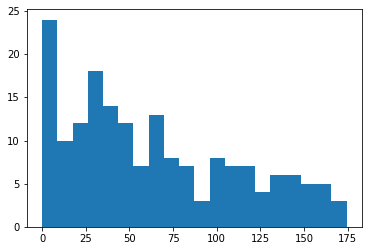

In [13]:
# sum line by line of matrix alpha and show histogram
sum = np.sum(matrix_alpha, axis=1)

# histogram of sum
import matplotlib.pyplot as plt
plt.hist(sum, bins=20)
plt.show()

In [15]:
# get mean and variance of sum
mean = np.mean(sum)
var = np.var(sum)

print(mean, var)

64.41340782122904 2354.23391085727


In [ ]:
# maximum a posteriori ranking
# for exponential prior

# n = number of competitors
n = matrix_alpha.shape[0]

prior_mean = 64
prior_var = 2354

posterior_mean = np.zeros(n)
posterior_var = np.zeros(n)

# iterate through competitors
for i in range(n):
    # likelihood mean
    likelihood_mean = np.sum(matrix_alpha[i])/(n-1)
    # likelihood variance
    likelihood_var = np.var(matrix_alpha[i])

    # posterior mean
    posterior_mean[i] = (likelihood_var * prior_mean + prior_var * likelihood_mean)/(prior_var + likelihood_var)
    # posterior variance
    posterior_var[i] = 1/(1/prior_var + 1/likelihood_var)

# get the ranking
ranking = pd.DataFrame(posterior_mean, index=competitor_to_index.keys(), columns=['ranking'])
ranking = ranking.sort_values(by='ranking', ascending=False)
